In [928]:
%matplotlib inline

In [929]:
import numpy as np

# Framework
days = 365 * 1
dt   = 0.01 # units: days

# Parameters
par = {}
par['AE_P']    = 0.9  # growth rate of pythoplankton (units: d^-1)
par['AE_D']    = 0.2    # half-saturation for nutrient absoption by pythoplankton (units: mmolN m^-3)
par['AE_Z']    = 0.3  # growth rate of zooplankton (units: d^-1)
par['Bpub']    = 0.43  # initial slope of ingestion saturation of zooplankton (units: mmol N^-1 m^3)
par['Fmax_ref'] = 0.025# initial slope of P vs I curve (units: {mmolN m^-3}^-1)
par['GT']       = 0.44
par['KTempH']   = 0.1    # half-saturation for phytoplankton absoption by mussels (units: mmolN m^-3)
par['KTempL']   = 0.5 # mortality rate of pythoplankton (units: d^-1)
par['KSaltL']   = 0.25 # mortality rate of zooplankton (units: d^-1)
par['KOxyL']    = 0.02 # mortality rate of zooplankton (units: d^-1)
par['KFood']    = 1.    # half-saturation for phytoplankton feeding by mussels due to mussel size (units: mmolN m^-3)
par['KRE']   = 0.86    # half-saturation for phytoplankton feeding by mussels (units: mmolN m^-3)
par['OxyL']  = 17.5
par['Rm']    = 0.002
par['SaltL'] = 10.
par['TempH'] = 25.
par['TempL'] = -4.
par['beta']  = 0.12
par['epsilonP'] = 1.
par['epsilonD'] = 0.5
par['epsilonZ'] = 0.3
# These are, for now, constant parameters. But will eventually Initial Conditions
par['Temp'] = 10. #Temperature
par['Salt'] = 30. #Salinity
par['Oxy'] = 30. #Oxygen
par['Phy'] = 10. #Phyto
par['Zoo'] = 1. #Zoo
par['SDet'] = 1. #SDet

# Initial conditions
Init = np.zeros(4)
Init[0] = 1. #Soma
Init[1] = 0.5 #Gonad
Init[2] = Init[0] + Init[1] #Biomass

# Chores (calculate timestemps, create zero vectors, create time vector)
NoSTEPS = int(days / dt) # Calculates the number of steps by dividing days by dt and rounding down
t = np.linspace(0,days,NoSTEPS) # Makes and vector array of equally spaced numbers from zero to "days"

In [930]:
def Mussel_Ibarra(Init,t,par):
    '''
    '''
    import numpy as np
    
    # Initializing with initial conditions
    Soma = Init[0] #Soma
    Gonad = Init[1] #Gonad
    B = Init[2] #Biomass
    
    # More.. Initializing with initial conditions (using constant parameters)
    Temp = par['Temp']
    Salt = par['Salt']
    Oxy = par['Oxy']
    Phy = par['Phy']
    Zoo = par['Zoo']
    SDet = par['SDet']
    
    # Create empty arrays
    dxdt = np.zeros(4)
    
    # Calculate Temperature Limitation
    L_Temp = min(max(0.,1.-np.exp(-par['KTempL']*(Temp-par['TempL']))), \
                 max(0.,1.+((1.-np.exp(par['KTempH']*Temp))/(np.exp(par['KTempH']*par['TempH'])-1.))))
    
    # Calculate Salinity Limitation
    L_Salt = max(0.,1.-np.exp(-par['KSaltL']*(Salt-par['SaltL'])))
    
    # Calculate Oxygen Limitation
    L_Oxy = max(0.,1.-np.exp(-par['KOxyL']*(Oxy-par['OxyL'])))
    
    # Calculate Oxygen Limitation
    L_Food = (Phy+Zoo+SDet)/(par['KFood']+Phy+Zoo+SDet)
    
    # Calculate Filtration rate
    Fmax  = par['Fmax_ref']*(B**(2./3.))
    
    F = Fmax * L_Temp * L_Salt * L_Oxy * L_Food
    
    A = F * ((par['epsilonP']*par['AE_P']*Phy)+ \
             (par['epsilonZ']*par['AE_Z']*Zoo)+ \
             (par['epsilonD']*par['AE_D']*SDet))
    
    R = (par['Rm']*B) + (par['beta']*A)
    
    RE = max(0., (B-par['Bpub'])/(par['KRE'] + B - (2.*par['Bpub'])))
    
    # Spawning
#     print Gonad/B
    if Gonad/B < par['GT']:
        Spawning = 0.
    elif Gonad/B >= par['GT'] and B>par['Bpub']:
        Spawning = Gonad
        Gonad = 0.
    
#     Soma = (A-R) * (1.-RE)
#     Gonad =  ((A-R) * RE) - Spawning
#     B = Soma + Gonad
    
    dxdt[0] = (A-R) * (1.-RE)
    dxdt[1] = ((A-R) * RE) - Spawning
    dxdt[2] = ((A-R) * (1.-RE))+(((A-R) * RE) - Spawning)
    
    return dxdt

In [931]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Run the model
dxdt = odeint(Mussel_Ibarra, Init, t, args=(par,), hmax=dt, hmin=dt)



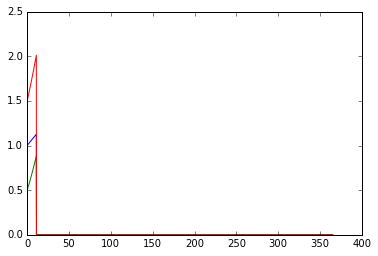

In [932]:
# Plotting
fig, (ax) = plt.subplots(1,1)
ax.plot(t,dxdt[:,0],'b-')
ax.plot(t,dxdt[:,1],'g-')
ax.plot(t,dxdt[:,2],'r-')
plt.show()